# Lab 2 - CNN and transfer Learing

How to implement models based on CNNs in tensorflow/keras and examples of how to transfer the knowledge between different tasks.

In [1]:
# Import libraries

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import PIL 
import os

### Download and prepare the dataset
This lab shows how to classify images of flowers.
It creates an image classifier using a `keras` model, and loads data using `tf.keras.utils.image_dataset_from_directory`. 

The first model building example follows a basic machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

In [2]:
!wget "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz" 
!tar -xf flower_photos.tgz

--2023-04-17 08:09:22--  https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 142.251.10.128, 142.251.12.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228813984 (218M) [application/x-compressed-tar]
Saving to: ‘flower_photos.tgz’

flower_photos.tgz   100%[===================>] 218.21M  22.1MB/s    in 11s     

2023-04-17 08:09:33 (20.3 MB/s) - ‘flower_photos.tgz’ saved [228813984/228813984]



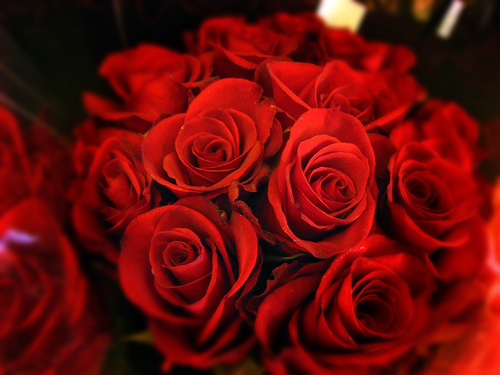

In [3]:
# Inspect the dataset and show a random image
PIL.Image.open('/content/flower_photos/roses/1485142251_ca89254442.jpg')

In [4]:
# Load data using a Keras utility, from disk

# Fixed dimension for the images
dim = 180

seed = 42

# Generates a tf.data.Dataset from image files in a directory:

data = tf.keras.utils.image_dataset_from_directory(
    'flower_photos',
    validation_split = 0.2,
    subset = 'both',
    seed = seed,
    image_size = (dim,dim),
    batch_size = 32)
# And divide it into train and validation
 
train_ds, val_ds = data


Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Using 734 files for validation.


In [5]:
class_names = train_ds.class_names
print(class_names)
num_classes = len(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Visualize the data

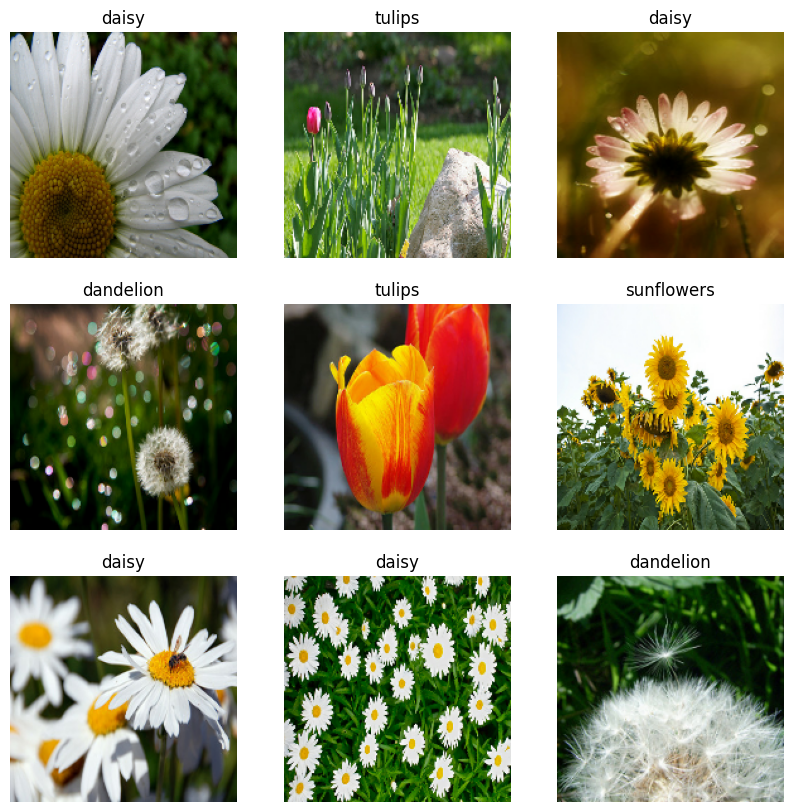

In [6]:
# First nine images of the training dataset

plt.figure(figsize = (10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[labels[i]])
    plt.axis('off')

### Create the convolutional model

In order to map all the channels of the images in the range [0,1], it is possible to apply a *rescaling* layer, to normalize the input.

As follows, we'll see defined the convolutional base using a common pattern: a stack of Conv2D and MaxPooling2D layers.
As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size.

In [7]:
# Import from keras models and layers

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Rescaling

# Define the model

def build_model(input_shape, num_classes):

  input = Input(shape = input_shape)
  rescaling = Rescaling(1./255)(input)

  c1 = Conv2D(16, 3, padding = 'same', activation = 'relu')(rescaling)
  p1 = MaxPooling2D((2,2))(c1)
  c2 = Conv2D(32, 3, padding = 'same', activation = 'relu')(p1)
  p2 = MaxPooling2D((2,2))(c2)
  c3 = Conv2D(64, 3, padding = 'same', activation = 'relu')(p2)
  p3 = MaxPooling2D((2,2))(c3)

  flattened = Flatten()(p3)

  dense_1 = Dense(128, activation = 'relu')(flattened)
  dense_2 = Dense(num_classes)(dense_1)

  model = Model(input, dense_2)
  model.summary()

  return model

model = build_model((dim,dim,3), num_classes)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                         

### Compile the model

Using a last layer with a `softmax` activation and `SparseCategoricalCrossentropy(from_logits = False)` is theoretically equivalent to omit the activation function and set `from_logits = True`. 
This, though, in tensorflow is not always true and it is always better to exploit the `from_logits` parameter.

In [8]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=1e-3), loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), metrics = ['accuracy'])


### Train the model

In [9]:
model_fit = model.fit(train_ds, epochs = 10, validation_data = val_ds)

Epoch 1/10
92/92 [==============================] - 20s 75ms/step - loss: 1.3349 - accuracy: 0.4557 - val_loss: 1.0714 - val_accuracy: 0.5926
Epoch 2/10
92/92 [==============================] - 8s 79ms/step - loss: 1.0081 - accuracy: 0.6114 - val_loss: 1.0566 - val_accuracy: 0.5722
Epoch 3/10
92/92 [==============================] - 6s 62ms/step - loss: 0.8188 - accuracy: 0.6887 - val_loss: 0.9539 - val_accuracy: 0.6335
Epoch 4/10
92/92 [==============================] - 7s 76ms/step - loss: 0.6008 - accuracy: 0.7854 - val_loss: 0.9639 - val_accuracy: 0.6526
Epoch 5/10
92/92 [==============================] - 6s 60ms/step - loss: 0.4127 - accuracy: 0.8614 - val_loss: 1.1578 - val_accuracy: 0.6281
Epoch 6/10
92/92 [==============================] - 6s 62ms/step - loss: 0.2369 - accuracy: 0.9203 - val_loss: 1.3840 - val_accuracy: 0.6144
Epoch 7/10
92/92 [==============================] - 7s 74ms/step - loss: 0.1638 - accuracy: 0.9472 - val_loss: 1.5471 - val_accuracy: 0.6281
Epoch 8/10
9

In [10]:
# Define a display_history function in order to visualize the behavior 
# of the loss and of the accuracy during training.

def display_history(model_fit):
  mse_training = model_fit.history['loss']
  acc_training = model_fit.history['accuracy']

  mse_val = model_fit.history['val_loss']
  acc_val = model_fit.history['val_accuracy']

  plt.plot(mse_training)
  plt.plot(mse_val)
  plt.grid()
  plt.title('Loss during training')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Validation'])
  plt.show()

  plt.plot(acc_training)
  plt.plot(acc_val)
  plt.grid()
  plt.title('Loss during training')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Validation'])
  plt.show()



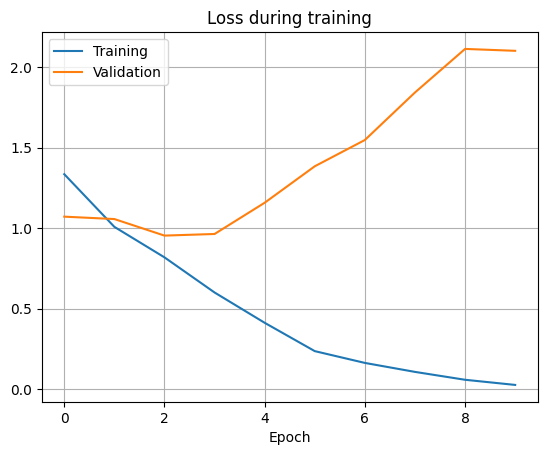

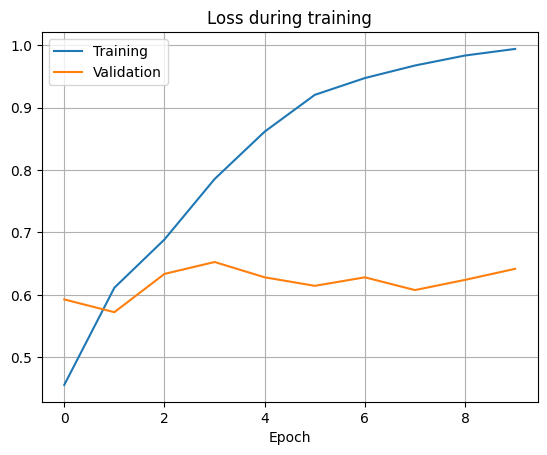

In [11]:
display_history(model_fit)

It is possible to see that loss and accuracy in both the visualizations are not coherent considering training and validation. Hence, it is present *overfitting*. Next, we'll see how to eliminate it.

## Overfitting elimination techniques

When the training examples are in a small number, the model can learn from noises or unwated details from training examples to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as *overfitting*. Two ways of overcoming the *overfitting* are: **Data augmentation** and add **Dropout** to the model.

### Data augmentation

Additional training data generated from existing examples by augmenting them using random trasnformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better. 

In [12]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom

data_augmentation = lambda input_shape: tf.keras.Sequential([
    RandomFlip('horizontal', input_shape = input_shape),
    RandomRotation(0.1),
    RandomZoom(0.1),
    ]
)

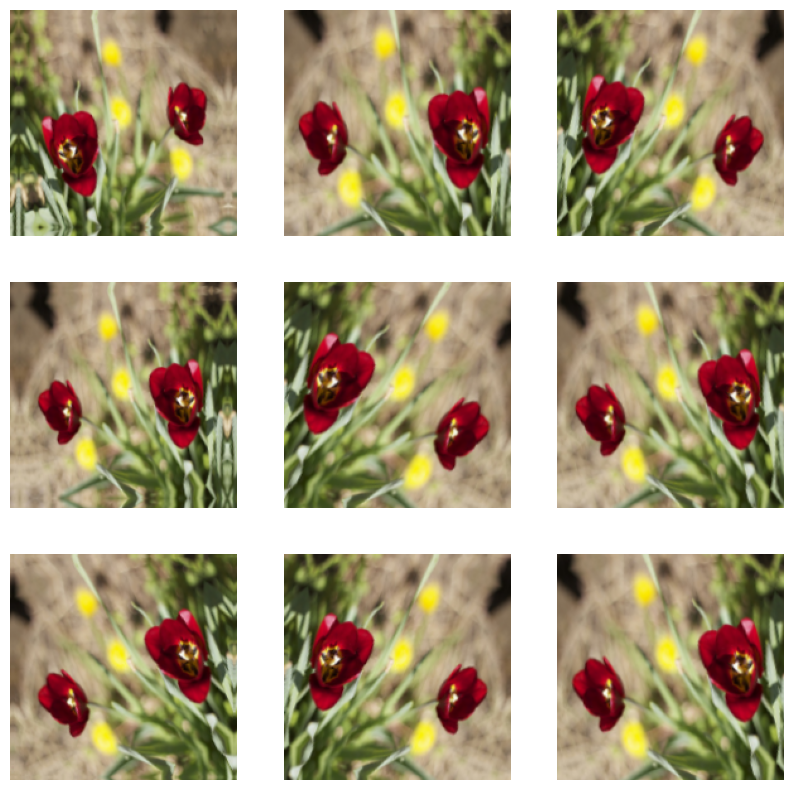

In [13]:
# Display augmented images
plt.figure(figsize=(10,10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = (data_augmentation((dim,dim,3)))(images)
    ax = plt.subplot(3,3,i+1)
    plt.imshow(augmented_images[0].numpy().astype('uint8'))
    plt.axis('off')

### Dropout

*Dropout* regularization to the network. Applying dropout to a layer randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, such as 0.1, 0.2, 0.4, dropping out 10%, 20%, 40% of the output units randomly from the applied layer.

A new NN need to be created before training it using the augmented images.

In [14]:
# New NN exploiting Dropout layer

from tensorflow.keras.layers import Dropout

def get_enhanced_model(input_shape, num_classes):

  input = Input(input_shape)

  augmented = (data_augmentation(input_shape))(input)

  r = Rescaling(1./255)(augmented)

  c1 = Conv2D(16, 3, padding='same', activation='relu')(r)
  p1 = MaxPooling2D((2, 2))(c1)
  c2 = Conv2D(32, 3, padding='same', activation='relu')(p1)
  p2 = MaxPooling2D((2, 2))(c2)
  c3 = Conv2D(64, 3, padding='same', activation='relu')(p2)
  p3 = MaxPooling2D((2, 2))(c3)
  d = Dropout(.4)(p3)
  f = Flatten()(d)
  d1 = Dense(128, activation='relu')(f)
  d2 = Dense(num_classes)(d1)

  model = Model(input, d2)

  model.summary()

  return model

model = get_enhanced_model((dim,dim,3), num_classes)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_9 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                           

In [15]:
from tensorflow.keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='val_accuracy',
                         mode = 'max',
                         patience = 3,
                         restore_best_weights = True)

model.compile(optimizer=Adam(learning_rate=1e-3), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model_fitting = model.fit(train_ds, epochs=10, validation_data = val_ds, callbacks = [callback])

Epoch 1/10
92/92 [==============================] - 10s 81ms/step - loss: 1.3577 - accuracy: 0.4206 - val_loss: 1.1424 - val_accuracy: 0.4905
Epoch 2/10
92/92 [==============================] - 6s 63ms/step - loss: 1.0807 - accuracy: 0.5603 - val_loss: 1.0550 - val_accuracy: 0.5777
Epoch 3/10
92/92 [==============================] - 6s 63ms/step - loss: 0.9705 - accuracy: 0.6104 - val_loss: 0.9612 - val_accuracy: 0.6240
Epoch 4/10
92/92 [==============================] - 7s 78ms/step - loss: 0.9109 - accuracy: 0.6427 - val_loss: 0.8826 - val_accuracy: 0.6594
Epoch 5/10
92/92 [==============================] - 8s 87ms/step - loss: 0.8237 - accuracy: 0.6832 - val_loss: 0.8548 - val_accuracy: 0.6812
Epoch 6/10
92/92 [==============================] - 7s 72ms/step - loss: 0.7714 - accuracy: 0.7003 - val_loss: 0.8449 - val_accuracy: 0.6771
Epoch 7/10
92/92 [==============================] - 10s 108ms/step - loss: 0.7669 - accuracy: 0.7081 - val_loss: 0.8685 - val_accuracy: 0.6649
Epoch 8/10

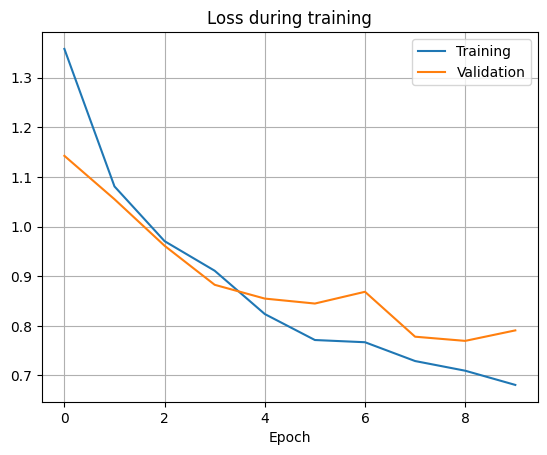

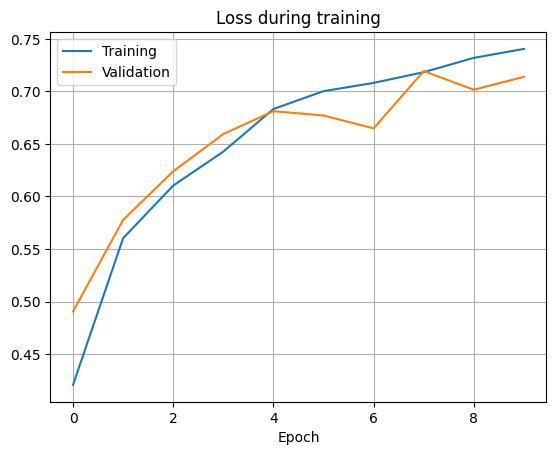

In [16]:
display_history(model_fitting)

Definitely improved.

## Transfer learning

Pre-trained models are saved networks previously trained on a large dataset, tipically a large-scale calssification task. Transfer learning is used to custumize the model to a given task.

The intuition behind transfer learning for image classification is that if a model is trained on a large and general enough dataset, this model will effectively serve as a generic model. You can then take advantage of these learned feature maps without having to start from scratch by training a large model on a large dataset.

A pre-trained model can be used in two ways:
- *Feature extraction*: Use the representations learned by a previous network to extract meaningful features from new samples. You simply add a new classifier, which will be trained from scratch, on top of the pretrained model so that you can repurpose the feature maps learned previously for the dataset. You do not need to (re)train the entire model. The base network already contains features that are generically useful for the task. However, the final classification part of the pretrained model is specific to the original classification task and subsequently specific to the set of classes on which the model was trained.

- *Fine-Tuning*: Unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This allows us to "fine-tune" the higher-order feature representations in the base model in order to make them more relevant for the specific task.

#### Build the Model

Create the base model starting from the **MobileNet V2**, developed at Google, pre-trained model on the ImageNet dataset, a large dataset consisting of 14M images and 1000 classes. 

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [17]:
# Instantiate the base model

base_model = tf.keras.applications.MobileNetV2(input_shape = (dim,dim,3),
                                               include_top = False,
                                               weights = 'imagenet')

9406464/9406464 [==============================] - 2s 0us/step


In [18]:
# Base model architecture

base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 90, 90, 32)   864         ['input_3[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 90, 90, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 90, 90, 32)   0           ['bn_Conv1[0][

### Feature Extraction

Over here, we're going to *freeze* the conv base created from the previous step to use as a feature extractor. Next, a classifier is added on top of it and it is required to train the top-level-classifier.

Freezing (by setting layer.trainable = False) the conv base before compiling and training the model is important because it prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's **trainable** flag to False will freeze all of them.


In [19]:
# Freeze the conv base

base_model.trainable = False

**tf.keras.layers.BatchNormalization** is a special case layer, and precautions should be taken in the context of fine-tuning. When setting layer.trainable = False, the BatchNormalization layer will run in inference mode and not update its mean and varience statistics. 

Thus, when unfreezing a model that contains BatchNormalization layers in order to do fine-tuning, we should keep the BatchNormalization layers in infernce mode by passing training = False when calling the base model; otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

In [20]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 90, 90, 32)   864         ['input_3[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 90, 90, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 90, 90, 32)   0           ['bn_Conv1[0][

Add the classifier on top:

In [21]:
from tensorflow.keras.layers import GlobalAveragePooling2D

def trans_learning_model(input_shape):

  input = tf.keras.Input(shape=input_shape)

  aug = (data_augmentation(input_shape))(input)

  rescaling = Rescaling(1./127.5, offset=-1)(aug)

  m_n = base_model(rescaling, training = False)

  gap = GlobalAveragePooling2D()(m_n)

  d = Dropout(0.2)(gap)

  out = Dense(num_classes)(d)

  model = tf.keras.Model(input, out)

  model.summary()
  return model

model = trans_learning_model((dim,dim,3))


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_10 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 6, 6, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0   

In [22]:
starting_learning_rate = 1e-4
initial_epochs = 10

model.compile(optimizer=Adam(learning_rate=starting_learning_rate),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics = ['accuracy'])

model_fit = model.fit(train_ds, epochs=initial_epochs, validation_data = val_ds)


Epoch 1/10
92/92 [==============================] - 16s 114ms/step - loss: 1.6844 - accuracy: 0.3345 - val_loss: 1.3122 - val_accuracy: 0.4578
Epoch 2/10
92/92 [==============================] - 12s 126ms/step - loss: 1.2686 - accuracy: 0.4980 - val_loss: 1.0234 - val_accuracy: 0.5967
Epoch 3/10
92/92 [==============================] - 6s 67ms/step - loss: 1.0212 - accuracy: 0.6097 - val_loss: 0.8446 - val_accuracy: 0.7003
Epoch 4/10
92/92 [==============================] - 8s 85ms/step - loss: 0.8929 - accuracy: 0.6631 - val_loss: 0.7464 - val_accuracy: 0.7466
Epoch 5/10
92/92 [==============================] - 7s 78ms/step - loss: 0.7778 - accuracy: 0.7136 - val_loss: 0.6684 - val_accuracy: 0.7861
Epoch 6/10
92/92 [==============================] - 7s 69ms/step - loss: 0.7356 - accuracy: 0.7316 - val_loss: 0.6177 - val_accuracy: 0.8038
Epoch 7/10
92/92 [==============================] - 8s 78ms/step - loss: 0.6636 - accuracy: 0.7537 - val_loss: 0.5814 - val_accuracy: 0.8106
Epoch 8/1

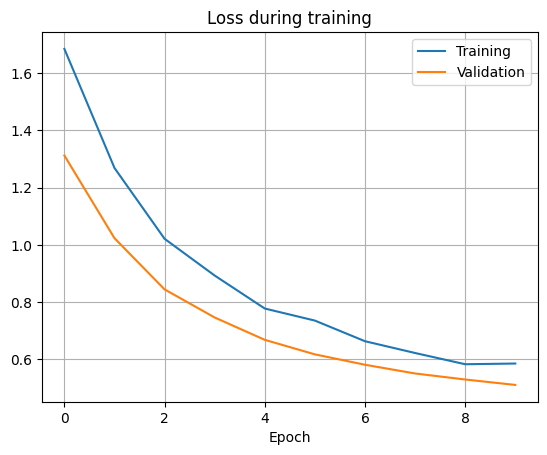

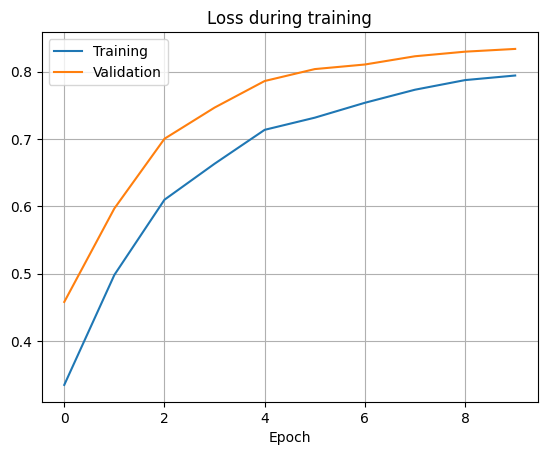

In [23]:
display_history(model_fit)

## Fine Tuning

In the feature extraction experiment, you were only training a few layers on top of an MobileNetV2 base model. The weights of the pre-trained network were not updated during training.

It is possible to improve performance even further through *fine-tuning*, training the weights of the top layers of the pre-trained model alongside the training of the classifier that has been added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Then, it is better to try to fine-tune a small number of top layers rather than the whole MobileNet model. In most CNN, the higher up the layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all type of images. Going higher up, the features are increasingly more specific to the dataset on which the model was trained. 

The **goal** of *fine-tuning* is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

In [24]:
base_model.trainable = True

# Number of layers in the base model
print('Number of layers in the base model: ', len(base_model.layers))

# Impose the layer from which the Fine-Tuning is starting
fine_tune_start = 100

# Freeze all the layers before the fine_tune_start layer
for layer in base_model.layers[:fine_tune_start]:
  layer.trainable = False

Number of layers in the base model:  154


## Compile the model

Once it is necessary to train a larger model, the pre-trained weights need to be readapted. In this case, it is important to use a lower learning rate, or else the model could overfit very quickly. 

In [26]:
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate = starting_learning_rate/10),
              metrics = ['accuracy'])

In [32]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

model_fit_fine_t = model.fit(train_ds, epochs = total_epochs,
                         initial_epoch = model_fit.epoch[-1],
                         validation_data = val_ds)

Epoch 10/20
92/92 [==============================] - 7s 73ms/step - loss: 0.1475 - accuracy: 0.9445 - val_loss: 0.2739 - val_accuracy: 0.9033
Epoch 11/20
92/92 [==============================] - 8s 84ms/step - loss: 0.1311 - accuracy: 0.9523 - val_loss: 0.3145 - val_accuracy: 0.9019
Epoch 12/20
92/92 [==============================] - 8s 84ms/step - loss: 0.1166 - accuracy: 0.9608 - val_loss: 0.3263 - val_accuracy: 0.8992
Epoch 13/20
92/92 [==============================] - 7s 74ms/step - loss: 0.1198 - accuracy: 0.9584 - val_loss: 0.2730 - val_accuracy: 0.9060
Epoch 14/20
92/92 [==============================] - 8s 85ms/step - loss: 0.1011 - accuracy: 0.9639 - val_loss: 0.2885 - val_accuracy: 0.9046
Epoch 15/20
92/92 [==============================] - 9s 90ms/step - loss: 0.0938 - accuracy: 0.9717 - val_loss: 0.3325 - val_accuracy: 0.9046
Epoch 16/20
92/92 [==============================] - 7s 72ms/step - loss: 0.0848 - accuracy: 0.9700 - val_loss: 0.3029 - val_accuracy: 0.9087
Epoch 

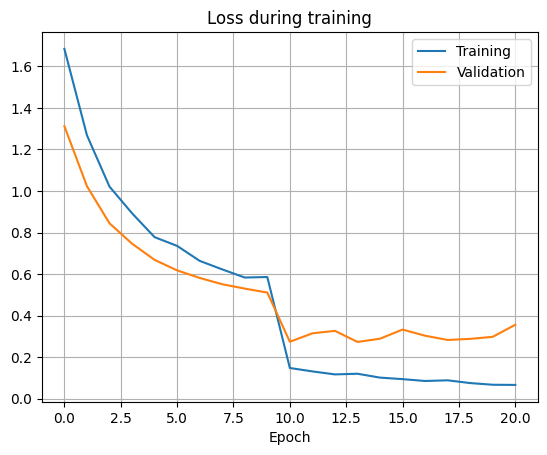

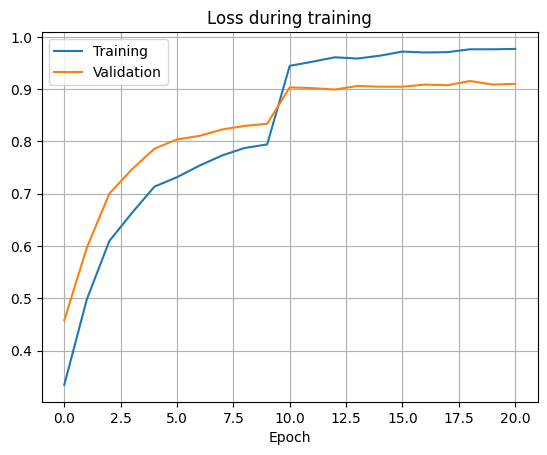

In [33]:
model_fit.history['accuracy'] += model_fit_fine_t.history['accuracy']
model_fit.history['val_accuracy'] += model_fit_fine_t.history['val_accuracy']

model_fit.history['loss'] += model_fit_fine_t.history['loss']
model_fit.history['val_loss'] += model_fit_fine_t.history['val_loss']

display_history(model_fit)